In [12]:
# Import packages.
import sys
!{sys.executable} -m pip install h5py
import h5py
import xml.etree.ElementTree as ET
import os
import readGalacticusData
import numpy as np
import random
import matplotlib.pyplot as plt

# TODO: Move to appropriate directory here.
cwd = "/central/home/emin/Galacticus/galacticus"
os.chdir(cwd)
print("Done importing and transporting to directory.")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/central/software/python/3.7.0/bin/python3.7 -m pip install --upgrade pip' command.
Done importing and transporting to directory.


In [13]:
def genHaloMassFile(haloMassList, filePath):
    '''
    Writes a .hdf5 halo mass file to filePath given a list of halo masses.
    Weights are set default to 1.0.
    '''
    masses = haloMassList
    weights = [1.0] * len(haloMassList)
    with h5py.File(filePath, 'w') as f:
        f.create_dataset('treeRootMass', data=masses)
        f.create_dataset('treeWeight', data=weights)
        f.close()

def genSampleHaloMassList(start, numHalos):
    '''
    Generates a halo mass list of length numHalos. 
    Starts at 10^(start) and increases in magnitude of 10.
    '''
    masses = np.array([pow, 10.0, _] for _ in range(start, start+numHalos))
    return masses

def getMassResolution(mass):
    '''
    Sample function to get mass resolution based on mass.
    Here it is scaled by 3e-4.
    '''
    return mass*3*pow(10.0, -4)

# Generate parameter file.
def genParameterFile(templateFilePath, outputDirectory, haloMassList, replicationCount, massResolution):
    '''
    Generates a parameter file from a template given the input parameters.
    Returns the new simulation number and parameter file path.
    
    templateFilePath: path containing template parameter file to generate new parameter file from
    outputDirectory: relative directory to store generated input and output files
                     (can be empty string '' if current directory is OK)
    haloMassList: Python list of halos to compute at
    replicationCount: replication count of halo populations
    massResolution: desired mass resolution of simulations.
    '''
    simulationNumber = random.randrange(100000)
    print("SIMULATION NO. " + str(simulationNumber))
    print("----------------------------------------------------------------")

    tree = ET.parse(templateFilePath)
    root = tree.getroot()

    inputFilePath = outputDirectory + 'halo_mass_list_' + str(simulationNumber) + '.hdf5'
    genHaloMassFile(haloMassList, inputFilePath)
    outputFilePath = outputDirectory + 'halo_mass_output_' + str(simulationNumber) + '.hdf5'
  
    for mergerTree in root.findall('mergerTreeBuildMasses'):
        for replicate in mergerTree.findall('replicationCount'):
            replicate.set('value', str(replicationCount))
        for subTree in mergerTree.findall('mergerTreeBuildMasses'):
            for inputFile in subTree.findall('fileName'):
                inputFile.set('value', inputFilePath)
  
    for mergerTreeMassRes in root.findall('mergerTreeMassResolution'):
        for massRes in mergerTreeMassRes.findall('massResolution'):
            massRes.set('value', str(massResolution))
  
    for outputFile in root.findall('outputFileName'):
        outputFile.set('value', outputFilePath)
  
    paramFile = outputDirectory + 'parameter_file_' + str(simulationNumber) + ".xml"
    tree.write(paramFile)
    return simulationNumber, paramFile

print("Compiled helper functions for running Galacticus.")

Compiled helper functions for running Galacticus.


In [14]:
def convert_Mpc_to_kpc(subHaloData):
    '''
    Converts a list of hdf5 subhalo data from Mpc to kpc.
    '''
    haloMass = readGalacticusData.halo.readHostProperty(subHaloData, 'basicMass') 
    v_min = np.floor(np.log10(haloMass) - 5)
    v_max = np.floor(np.log10(haloMass) - 1)
    masses_virInfall = np.log10(subHaloData.MvirInfall()) 
    arg = np.argsort(subHaloData.Vmax())
    ind = np.sort(masses_virInfall) > v_min
    
    conversion_factor = 1000
    
    x = subHaloData.positionX()[arg][ind][:-1]
    y = subHaloData.positionY()[arg][ind][:-1]
    
    x_kpc = [conversion_factor*_ for _ in x]
    y_kpc = [conversion_factor*_ for _ in y]
    return x_kpc, y_kpc

def visualize_subhalos(subHaloData, scaleFactor):
    '''
    Visualizes subhalos given a hdf5 set of subhalo data and desired scale factor,
    which affects the size of the individual halos in the visualization.
    '''
    haloMass = readGalacticusData.halo.readHostProperty(subHaloData, 'basicMass')
    v_min = np.floor(np.log10(haloMass) - 5)
    v_max = np.floor(np.log10(haloMass) - 1)
    
    masses_virInfall = np.log10(subHaloData.MvirInfall())
    
    plt.figure(figsize=(6,6))
    
    plt.title("Subhalo population for mass of magnitude " + str(np.floor(np.log10(haloMass))))
    
    arg = np.argsort(subHaloData.Vmax())
    ind = np.sort(masses_virInfall) > v_min
    
    x_kpc, y_kpc = convert_Mpc_to_kpc(subHaloData)

    sc = plt.scatter(x_kpc, y_kpc,
                 s=scaleFactor*masses_virInfall[arg][ind][:-1],c=masses_virInfall[arg][ind][:-1],
                 vmin=v_min,vmax=v_max,cmap='Blues')

    cbar = plt.colorbar(sc,fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'$\log(M_{\mathrm{peak}}/M_{\mathrm{\odot}})$', fontsize=28, rotation=90)
    cbar.solids.set_rasterized(True)
    cir = plt.Circle((0,0),subHaloData.RvirHost*1000,fill=False,ec='k',ls='dashed',lw=2.0)

    plt.axes().add_artist(cir)
    plotLim = subHaloData.RvirHost*1000*1.25
    plt.xlim(-1*plotLim,plotLim)
    plt.ylim(-1*plotLim,plotLim)

    plt.axes().set_aspect('equal')
    plt.xlabel("$x\,[\\rm kpc]$",fontsize=28)
    plt.ylabel("$y\,[\\rm kpc]$",fontsize=28)

    plt.tight_layout()
    plt.show()
    
print("Compiled helper functions for visualizations.")

Compiled helper functions for visualizations.


In [15]:
# TODO: Specify parameters here.
templateFilePath='CASSI/week9/parameter_template.xml'
desiredDirectoryPath = 'CASSI/week9/'
haloMassList = np.array([10000000000000.0])
replicationCount = 1
massResolution = getMassResolution(haloMassList[0])

print("Done initializing parameters.")

Done initializing parameters.


SIMULATION NO. 88821
----------------------------------------------------------------
Running Galacticus and visualizing subhalos...
This may take 1-2 minutes.


/central/software/python/3.7.0/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


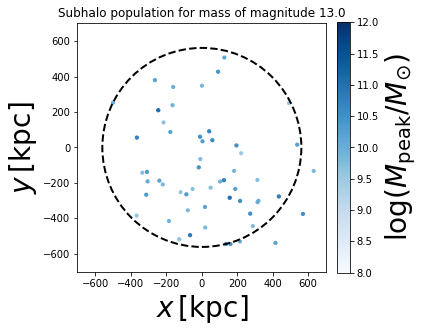

In [16]:
# Run Galacticus and visualize.
simulationNumber, paramFilePath = genParameterFile(templateFilePath, desiredDirectoryPath, haloMassList, replicationCount, massResolution)
print("Running Galacticus and visualizing subhalos...")
print("This may take 1-2 minutes.")
runHaloPopulationXML = "./Galacticus.exe " + paramFilePath
os.system(runHaloPopulationXML)

outputFilePath = desiredDirectoryPath + 'halo_mass_output_' + str(simulationNumber) + '.hdf5'
halo = {}
halo['MW'] = readGalacticusData.halo(outputFilePath, 0.0, 1)
#print("There are " + str(halo['MW'].NSubhalo) + " subhalos.")
visualize_subhalos(halo['MW'], 1)